In [36]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [37]:
# Setting path to input files
file = "Super_Sales.csv"

In [38]:
# Creating dataframes
df = pd.read_csv(file)

In [39]:
# Select relevant features and convert 'Order Date' to datetime
sales_df = df[['Order Date', 'Sales']]
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])

# Set 'Order Date' as index
sales_df.set_index('Order Date', inplace=True)

/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_22749/2571996550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])


In [40]:
# Resample the data on a monthly basis and aggregate the sales
monthly_sales = sales_df.resample('M').sum()

In [50]:
# Hyperparameter tuning
# Defining parameter grid for GridSearchCV

param_grid = {
    'n_estimators' :[100, 200, 300], # Number of trees in this forest
    'max_depth' : [3, 5, 7], # Maximum depth of the tree
    'learning_rate' : [0.05, 0.1, 0.2], # Learning rate
    'subsample' : [0.7, 0.8, 0.9], # Subsample ratio of training instance
    'colsample_bytree' : [0.7, 0.8, 0.9] # Subsample ratio of columns when constructing each tree
}

In [57]:

# Splitting data into training and testing sets
train = monthly_sales[:-15]  # Training data (all except last 16 months)
test = monthly_sales[-15:]   # Testing data (last 16 months)

In [58]:
# Initialize XGBoost model
xgb = XGBRegressor()

# Initialize GridSearchCV with the XGBoost model and parameter grid
grid_search = GridSearchCV(estimator = xgb, param_grid=param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Fit the GridSearchCV to the training data
grid_search.fit(train.index.month.values.reshape(-1, 1), train.values)

# Get the best hyperparameters
gs_params = grid_search.best_params_
print("Best hyperparameters", gs_params)

Best hyperparameters {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


In [59]:
# Use the best hyperparameters to train the final model
gs_model = XGBRegressor(**gs_params)
gs_model.fit(train.index.month.values.reshape(-1,1), train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
# Model without hyperparameters

# Initialize XGBoost model
model = XGBRegressor()

# Fit the model to the training data
model.fit(train.index.month.values.reshape(-1, 1), train.values)

# Predict on the test set
basic_predictions = model.predict(test.index.month.values.reshape(-1, 1))

# Evaluate rmse
basic_rmse = mean_squared_error(test.values, basic_predictions, squared=False)

In [61]:
# Predict on the test set
gs_predictions = gs_model.predict(test.index.month.values.reshape(-1, 1))

# Evaluate the model
gs_rmse = mean_squared_error(test.values, gs_predictions, squared=False)

In [62]:
# Finding rmse
print("GridSearch hyperparameter RMSE:", gs_rmse)
print("Basic TSF RMSE:", basic_rmse)

GridSearch hyperparameter RMSE: 21019.816184142266
Basic TSF RMSE: 20901.448136378054


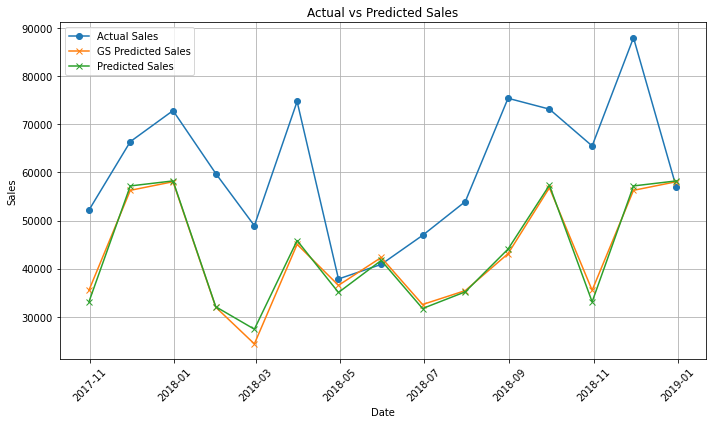

In [63]:
# Plotting results and comparing

plt.figure(figsize = (10,6))

# Plotting actual values
plt.plot(test.index, test.values, label = 'Actual Sales', marker = 'o')

# Plotting (hyperparameter) predicted values
plt.plot(test.index, gs_predictions, label = 'GS Predicted Sales', marker = 'x')

# Plotting basic predicted values
plt.plot(test.index, basic_predictions, label = 'Predicted Sales', marker = 'x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()

# Display plot
plt.grid(True)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()